In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date, dayofweek, hour, lag, mean, lit, when,avg
from pyspark.sql.window import Window
import json
from pyspark.sql.functions import rand, isnan, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import rand, round

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
from tensorflow.keras.utils import to_categorical

# Initialize a SparkSession
spark = SparkSession.builder.appName("PredictiveMaintenance").getOrCreate()

# Load your dataset into a PySpark DataFrame
df = spark.read.csv('/Users/mac/Downloads/predictive.csv', header=True, inferSchema=True)

# Assuming 'date_insertion' is the correct timestamp column based on your dataset schema
# Adjust the following transformations accordingly:

# Extract JSON fields function
def extract_from_json(column, key):
    try:
        json_data = json.loads(column.replace("'", "\""))
        return json_data.get(key, None)
    except:
        return None

# Registering the UDF
extract_from_json_udf = udf(extract_from_json)

# Step 1: Extracting 'oil_value' and 'fuel_liters'
df = df.withColumn("oil_value", extract_from_json_udf(col("details"), lit("oil_value")))
df = df.withColumn("fuel_liters", extract_from_json_udf(col("details"), lit("fuel_liters")))

# Step 2: Creating time-based features
df = df.withColumn("date_insertion", to_date(col("date_insertion")))
df = df.withColumn("day_of_week", dayofweek(col("date_insertion")))
df = df.withColumn("hour_of_day", hour(col("date_insertion")))



# Step 4: Aggregate readings on a daily basis
daily_avg_df = df.groupBy("thing_id", "date_insertion").agg(mean("power_supply_voltage").alias("daily_avg_voltage"))
df = df.join(daily_avg_df, ["thing_id", "date_insertion"], "left")

# Step 5: Create binary indicator for 'engine_status'
df = df.withColumn("engine_alert", when(col("engine_status") == "Abnormal", 1).otherwise(0))

# Define a UDF to generate random values within a range
def random_value(min_value, max_value):
    return (rand() * (max_value - min_value) + min_value).cast(FloatType())

# random_value_udf = udf(random_value, FloatType())

# Set min and max values for 'oil_value' and 'fuel_liters'
oil_value_min, oil_value_max = 0, 4
fuel_liters_min, fuel_liters_max = 0, 60

# Replace null values with random numbers
# Replace null values with random numbers and round to 1 decimal place
df = df.withColumn("oil_value", when(df['oil_value'].isNull(), round((rand() * (oil_value_max - oil_value_min) + oil_value_min), 1)).otherwise(df['oil_value']))
df = df.withColumn("fuel_liters", when(df['fuel_liters'].isNull(), round((rand() * (fuel_liters_max - fuel_liters_min) + fuel_liters_min), 1)).otherwise(df['fuel_liters']))

# Step 6: Generate interaction features
# df = df.withColumn("voltage_current_interaction", col("power_supply_voltage") * col("battery_current"))

# Step 3: Calculating rate of change for 'battery_current'
windowSpec = Window.partitionBy("thing_id").orderBy("date_insertion")
df = df.withColumn("battery_current_change", col("power_supply_voltage") - lag("power_supply_voltage", 1).over(windowSpec))


24/04/15 14:10:13 WARN Utils: Your hostname, MacBook-Air-de-mac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.9 instead (on interface en0)
24/04/15 14:10:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/15 14:10:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = df.select("thing_id", "date_insertion", "speed", "total_km", "engine_status", "power_supply_voltage" ,"oil_value", "fuel_liters",  "battery_current_change", "daily_avg_voltage")


from pyspark.sql import Window
from pyspark.sql.functions import lag, avg, stddev

# Define a window
window = Window.orderBy('date_insertion').rowsBetween(-9, 0)  # assuming 'date_insertion' is your time column

# Calculate rolling averages and standard deviations
df = df.withColumn('speed_avg', avg(df['speed']).over(window))
df = df.withColumn('oil_value_std', stddev(df['oil_value']).over(window))

# Calculate changes between consecutive readings
df = df.withColumn('speed_change', df['speed'] - lag(df['speed']).over(Window.orderBy('date_insertion')))
df = df.withColumn('fuel_change', df['fuel_liters'] - lag(df['fuel_liters']).over(Window.orderBy('date_insertion')))

# Step 7: Calculate rolling average


# Define a Window specification
# windowSpec = Window.orderBy('date_insertion').rowsBetween(-4, 0)  # 5 rows including current row

# Calculate rolling average
# df = df.withColumn('oil_quality_rolling_avg', avg(df['oil_value']).over(windowSpec))

# Show the first 5 rows of the DataFrame
df.show()


24/04/15 14:10:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 1

+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+------------------+------------------+------------+-------------------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|         speed_avg|     oil_value_std|speed_change|        fuel_change|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+------------------+------------------+------------+-------------------+
|     629|    2024-02-28|    0|334365360|            1|               22.25|      3.6|       42.8|                  NULL|          21.3035|              32.2|              NULL|        NULL|               NULL|
|     629|    2024-02-28|    1|334365360|            1|               22.18|      1.6|       46.6|  -0.07000000000000028|          21.3035|              27.

In [3]:
# Define thresholds
oil_value_fail_threshold = 1
oil_value_about_to_fail_threshold = 2

df = df.withColumn("car_age", when(rand() < 0.6, "old").otherwise("new"))

df = df.withColumn("last_oil_change", 
                   when(rand() < 0.25, "new")
                   .when((rand() >= 0.25) & (rand() < 0.5), "50km")
                   .when((rand() >= 0.5) & (rand() < 0.75), "80km")
                   .otherwise("old"))

df = df.withColumn("status", 
                   when((col("car_age") == "old") & (col("last_oil_change") == "old"), "fail")
                   .when((col("car_age") == "old") & (col("last_oil_change") == "80km"), "about to fail")
                   .when((col("car_age") == "old") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km")), "normal")
                   .when((col("car_age") == "new") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km") | (col("last_oil_change") == "80km")), "normal")
                   .otherwise("about to fail"))

# df = df.drop("date_insertion", "speed",)




df.show()


24/04/15 14:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 1

+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+------------------+------------------+------------+-------------------+-------+---------------+-------------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|         speed_avg|     oil_value_std|speed_change|        fuel_change|car_age|last_oil_change|       status|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+------------------+------------------+------------+-------------------+-------+---------------+-------------+
|     629|    2024-02-28|    0|334365360|            1|               22.25|      3.6|       42.8|                  NULL|          21.3035|              32.2|              NULL|        NULL|               NULL|    new|            old|about to fail|
|   

In [4]:
from pyspark.ml.feature import StringIndexer
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from pyspark.ml.feature import OneHotEncoder



df = df.withColumn("status", 
                   when(col("status") == "normal", 0)
                   .when(col("status") == "about to fail", 1)
                   .otherwise(2))

df = df.withColumn("car_age", 
                   when(col("car_age") == "old", 0)
                   .when(col("car_age") == "new", 1)



)


df = df.withColumn("last_oil_change", 
                   when(col("last_oil_change") == "new", 0)
                   .when(col("last_oil_change") == "50km", 1)
                   .when(col("last_oil_change") == "80km", 2)
                   .otherwise(3))

# Cast 'statusIndex' to integer

# Select features and label
features = df.drop('status')
label = df.select('status')

# Convert Spark DataFrame to pandas DataFrame
features_pd = features.toPandas()
label_pd = label.toPandas()


# Remove rows with any null value
features_pd = features_pd.dropna()
label_pd = label_pd.loc[features_pd.index] 

# Remove 'thing_id' and 'date' from features
features_pd = features_pd.drop(['thing_id', 'date_insertion','speed','total_km','battery_current_change','daily_avg_voltage'], axis=1)

print(features_pd.head())


# Convert pandas DataFrame to NumPy array
features_array = features_pd.values
label_array = label_pd.values

# Convert labels to one-hot encoded format
label_array = to_categorical(label_array, num_classes=3)

# Scale features to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features_array)



# Reshape to 3D array (batch_size, timesteps, input_dim)
scaled_features = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))

24/04/15 14:10:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 14:10:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/15 1

   engine_status  power_supply_voltage oil_value fuel_liters  speed_avg  \
1              1                 22.18       1.6        46.6  27.000000   
2              1                 22.20       2.3        30.3  23.285714   
3              1                 22.32       0.5        39.5  20.375000   
4              1                 22.22       3.5        57.9  18.111111   
5              0                 22.40       2.9        40.1  16.300000   

   oil_value_std  speed_change  fuel_change  car_age  last_oil_change  
1       1.414214           1.0          3.8        0                0  
2       1.014889           0.0        -16.3        0                2  
3       1.298717          -1.0          9.2        0                1  
4       1.309580           0.0         18.4        1                0  
5       1.196662           0.0        -17.8        0                1  


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(scaled_features.shape[1], scaled_features.shape[2])))
model.add(Dense(3,activation='softmax'))

/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer='adam')# Fit the model


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set

# Split the data into a training set and a test set
features_train, features_test, label_train, label_test = train_test_split(scaled_features, label_array, test_size=0.2, random_state=42)

# Train the model on the training set
history = model.fit(features_train, label_train, epochs=50, batch_size=72, validation_split=0.2, shuffle=False)

# Assuming 'model' is your trained Keras model
model.save('my_model.h5')

import joblib

# Assuming 'scaler' is your fitted MinMaxScaler
joblib.dump(scaler, 'my_scaler.pkl')

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1116 - val_loss: 1.0683
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0605 - val_loss: 1.0198
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0193 - val_loss: 0.9797
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9864 - val_loss: 0.9473
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9610 - val_loss: 0.9221
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9420 - val_loss: 0.9021
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9262 - val_loss: 0.8840
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9105 - val_loss: 0.8657
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8931 - val_loss: 0.8462
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8739 - val_loss: 0.8252
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8531 - val_loss: 0.8024
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8303 - val_loss: 0.7776
Epoch 13/50


['my_scaler.pkl']

dict_keys(['loss', 'val_loss'])


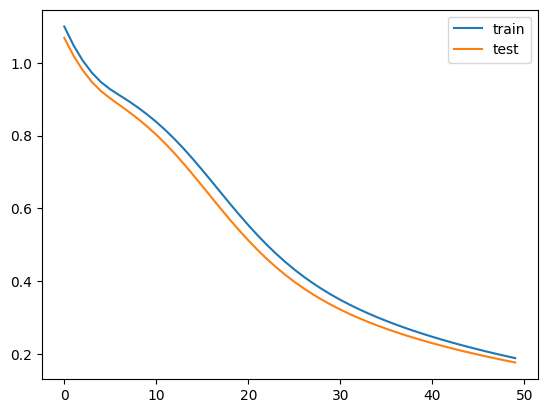

In [8]:
# Plot history
from matplotlib import pyplot
# Check the keys in the history object
print(history.history.keys())

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# Make predictions on the test set
predictions = model.predict(features_test)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


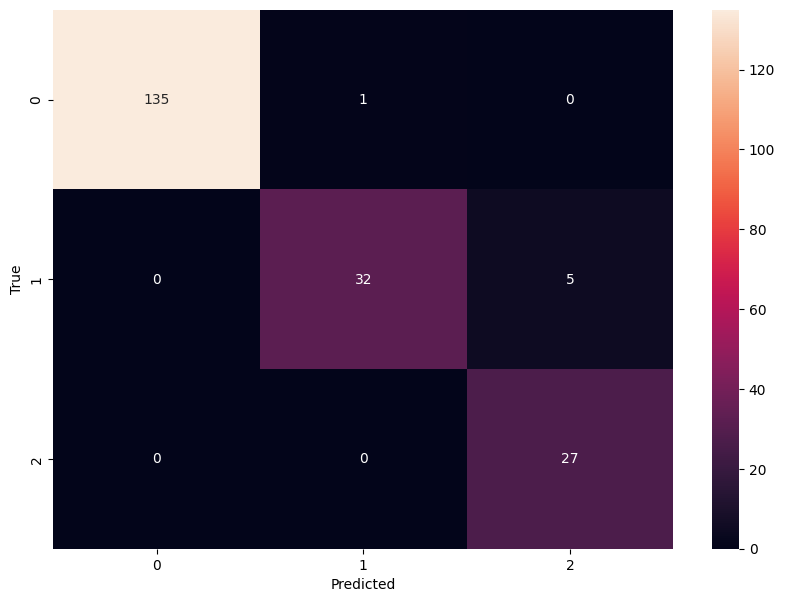

Recall: 0.97


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(features_test)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(label_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import recall_score

# Assuming y_test are the true labels and y_pred are the predicted labels
recall = recall_score(true_classes, predicted_classes, average='micro')  # for binary classification
print(f"Recall: {recall}")

In [18]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load your trained model
model = load_model('/Users/mac/prediction/my_model.h5')

# Load your fitted scaler
scaler = joblib.load('/Users/mac/prediction/my_scaler.pkl')

# Create a new test event
new_event = pd.DataFrame({
    'engine_status': [1],  # new engine_status
    'power_supply_voltage': [22.18],  # new power_supply_voltage
    'oil_value': [3.0],  # new oil_value
    'fuel_liters': [4.6],  # new fuel_liters
    'speed_avg': [27.0],  # new speed_avg
    'oil_value_std': [1.767767],  # new oil_value_std
    'speed_change': [1.0],  # new speed_change
    'fuel_change': [-3.6],  # new fuel_change
    'car_age': [0],  # new car_age
    'last_oil_change': [3]  # new last_oil_change
}, index=[0])

# Scale the new event using the saved scaler
new_event_scaled = scaler.transform(new_event)

# Reshape to 3D array (samples, timesteps, features)
new_event_array = new_event_scaled.reshape((1, 1, new_event_scaled.shape[1]))

# Use the Keras model to make a prediction
prediction = model.predict(new_event_array)

# Get the predicted class
predicted_class = np.argmax(prediction)

print(f"Predicted class: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted class: 2


/Users/mac/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
